In [1]:
import matplotlib.pyplot as plt

import torch
import numpy as np
import scipy.optimize as opt
import sys
sys.path.append("../")
from ddn.pytorch.node import *

from ddn.pytorch.learnable_projections import *
import random

In [2]:
node = L1Sphere()
x_init = torch.as_tensor(np.random.rand(10))
r_init=random.uniform(15, 20)
r_true=random.uniform(1, 5)
y_target = node.project(x_init,r_true)[0]
y_init = node.project(x_init,r_init)[0]


For L2 norm:
\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & u_1^2 + u_2^2 - r^2 = 0 \\
    & & 
\end{array}
\begin{array}{lll}
    Dy(r) =  r \cdot \frac {y} {y^T y}
\end{array}
For L1 norm and Ln norm:

\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & ||u||_n - r = 0 \\
    & & 
\end{array}

\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & ||u||_1 - r = 0 \\
    & & 
\end{array}

\begin{array}{lll}
    Dy(r) = \frac {a^T} {\| a\|_2^2}\\ 
   a= D_y h(r,y)
 \end{array}

In [3]:
def lbfgs(node, y_target, max_iters=1000, r_init=None, verbose=True):
    """
    Example of using scipy.optimize to solve the problem via L-BFGS.
    """
    # assert y_target.shape[0] == node.dim_y
    r_start = r_init if r_init is not None else 1.0
    def J(r):
        y, _ = node.project(x_init, r)
        #print('alphahh:',alpha)
        return  0.5 * ((y - y_target)**2).sum()
    def dJdr(r):
        y, _ = node.project(x_init, r)
       # print('gradient:',alpha ,node.gradient(x_init, y, alpha)[1])
        return  node.gradient((y - y_target),x_init, y)[1]
    history = [J(r_start)]
    rs=[r_start]
    ys=[node.project(x_init, r_start)]
    def callback(r):
        rs.append(r)
        history.append(J(r))
        ys.append(node.project(x_init, r))
    opts = {'maxiter': max_iters, 'disp': verbose}
    result = opt.minimize(J, r_init, args=(), method='L-BFGS-B', jac=dJdr, options=opts, callback=callback)
    return result.x, history,rs,ys
def simpleGradientDescent(node, y_target, step_size=1.0e-3, tol=1.0e-7, max_iters=10000, r_init=None, verbose=False):
    # assert y_target.shape[0] == node.dim_y
    r = r_init if r_init is not None else 1.0
    x = x_init
    J = lambda y : 0.5 * ((y - y_target)**2).sum()
    dJdy = lambda y : y - y_target
    
    history = []
    rs=[r]
    ys=[]
    for i in range(max_iters):
        # solve the lower-level problem and compute the upper-level objective
        y, _ = node.project(x,r)
        # print(torch.sum((y - y_target)**2) )
        history.append(J(y))
        if verbose: print("{:5d}: {}".format(i, history[-1]))
        if (len(history) > 2) and (history[-2] - history[-1]) < tol:
            break
        
        # compute the gradient of the upper-level objective with respect to x via the chain rule

        dJdr = node.gradient(dJdy(y),x,y)[1]
        # take a step in the negative gradient direction
        r -= step_size * dJdr
        rs.append(r.clone())
        ys.append(y)
    return r, history,rs,ys

In [4]:
r_gd1, history1,rs1,ys1 = lbfgs(node, y_target,max_iters=1000,r_init=r_init)
r_gd2, history2,rs2,ys2 = simpleGradientDescent(node, y_target,r_init=r_init,step_size=0.5)


hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Siz

In [5]:
print('r init:',r_init)
print('r true:',r_true)
print('r trained gd',r_gd1)
print('r trained lbfgs',r_gd2)
print('y init:', y_init)
print('y target:',y_target)
print('y trained gd:',node.project(x_init,r_gd1))
print('y trained lbfgs:',node.project(x_init,r_gd2))

r init: 18.5188436288367
r true: 3.549946770031773
r trained gd [3.54994677]
r trained lbfgs tensor(3.5536, dtype=torch.float64)
y init: tensor([1.4452, 1.6962, 1.5623, 2.0808, 1.7596, 1.8403, 2.1714, 2.2714, 2.2978,
        1.3937], dtype=torch.float64)
y target: tensor([0.0000, 0.1800, 0.0460, 0.5646, 0.2434, 0.3241, 0.6552, 0.7552, 0.7815,
        0.0000], dtype=torch.float64)
y trained gd: (tensor([0.0000, 0.1800, 0.0460, 0.5646, 0.2434, 0.3241, 0.6552, 0.7552, 0.7815,
        0.0000], dtype=torch.float64), None)
y trained lbfgs: (tensor([0.0000, 0.1804, 0.0465, 0.5650, 0.2439, 0.3245, 0.6556, 0.7556, 0.7820,
        0.0000], dtype=torch.float64), None)


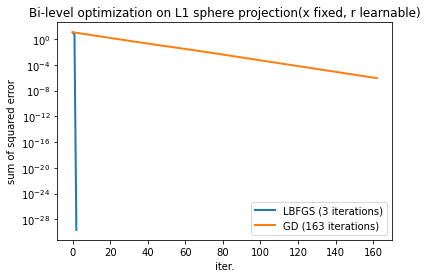

D:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


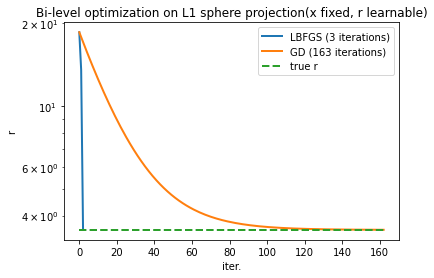

In [6]:

plt.figure()
plt.semilogy(history1, lw=2)
plt.semilogy(history2, lw=2)
plt.xlabel("iter."); plt.ylabel("sum of squared error")
plt.title("Bi-level optimization on L1 sphere projection(x fixed, r learnable)")
plt.legend(["LBFGS ({} iterations)".format(len(history1)),"GD ({} iterations)".format(len(history2))])
plt.show()

plt.figure()
plt.semilogy(rs1, lw=2)
plt.semilogy(rs2, lw=2)
plt.semilogy([r_true for i in range(len(rs2))], lw=2,linestyle='dashed')
plt.xlabel("iter."); plt.ylabel("r")
plt.title("Bi-level optimization on L1 sphere projection(x fixed, r learnable)")
plt.legend(["LBFGS ({} iterations)".format(len(history1)),"GD ({} iterations)".format(len(history2)),'true r'])
plt.show()

In [7]:
node = LInfSphere()
x_init = torch.as_tensor(np.random.rand(10))
r_init=random.uniform(15, 20)
r_true=random.uniform(1, 5)
y_target = node.project(x_init,r_true)[0]
y_init = node.project(x_init,r_init)[0]

In [8]:
r_gd1, history1,rs1,ys1 = lbfgs(node, y_target,max_iters=1000,r_init=r_init)
r_gd2, history2,rs2,ys2 = simpleGradientDescent(node, y_target,r_init=r_init,step_size=0.5)

..\ddn\pytorch\learnable_projections.py:313: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=v.dtype, device=v.device)


In [9]:
print('r init:',r_init)
print('r true:',r_true)
print('r trained gd',r_gd1)
print('r trained lbfgs',r_gd2)
print('y init:', y_init)
print('y target:',y_target)
print('y trained gd:',node.project(x_init,r_gd1))
print('y trained lbfgs:',node.project(x_init,r_gd2))

r init: 17.64490043798871
r true: 1.6549832687927415
r trained gd [1.65498327]
r trained lbfgs tensor(1.6552, dtype=torch.float64)
y init: tensor([ 0.3385,  0.2881, 17.6449,  0.1385,  0.0634,  0.8232,  0.4101,  0.0323,
         0.7134,  0.2616], dtype=torch.float64)
y target: tensor([0.3385, 0.2881, 1.6550, 0.1385, 0.0634, 0.8232, 0.4101, 0.0323, 0.7134,
        0.2616], dtype=torch.float64)
y trained gd: (tensor([0.3385, 0.2881, 1.6550, 0.1385, 0.0634, 0.8232, 0.4101, 0.0323, 0.7134,
        0.2616], dtype=torch.float64), None)
y trained lbfgs: (tensor([0.3385, 0.2881, 1.6552, 0.1385, 0.0634, 0.8232, 0.4101, 0.0323, 0.7134,
        0.2616], dtype=torch.float64), None)


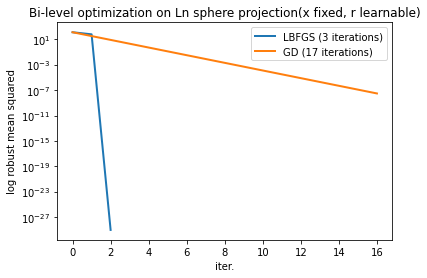

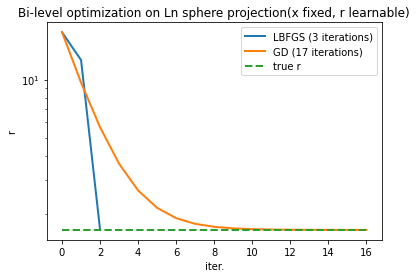

In [10]:
plt.figure()
plt.semilogy(history1, lw=2)
plt.semilogy(history2, lw=2)
plt.xlabel("iter."); plt.ylabel("log robust mean squared")
plt.title("Bi-level optimization on Ln sphere projection(x fixed, r learnable)")
plt.legend(["LBFGS ({} iterations)".format(len(history1)),"GD ({} iterations)".format(len(history2))])
plt.show()

plt.figure()
plt.semilogy(rs1, lw=2)
plt.semilogy(rs2, lw=2)
plt.semilogy([r_true for i in range(len(rs2))], lw=2,linestyle='dashed')
plt.xlabel("iter."); plt.ylabel("r")
plt.title("Bi-level optimization on Ln sphere projection(x fixed, r learnable)")
plt.legend(["LBFGS ({} iterations)".format(len(history1)),"GD ({} iterations)".format(len(history2)),'true r'])
plt.show()

In [11]:
def simpleGradientDescent(node, y_target, step_size=1.0e-3, tol=1.0e-7, max_iters=10000,x_init=None, r_init=None, verbose=False):
    # assert y_target.shape[0] == node.dim_y
    r = r_init if r_init is not None else 1.0
    x = x_init.clone() if x_init is not None else 1.0
    J = lambda y : 0.5 * ((y - y_target)**2).sum()
    dJdy = lambda y : y - y_target
    
    history = []
    rs=[]
    ys=[]
    for i in range(max_iters):
        # solve the lower-level problem and compute the upper-level objective
        
        y, _ = node.project(x,r)
        # print(torch.sum((y - y_target)**2) )
        history.append(J(y))
        if verbose: print("{:5d}: {}".format(i, history[-1]))
        if (len(history) > 2) and (history[-2] - history[-1]) < tol:
            break
        
        # compute the gradient of the upper-level objective with respect to x via the chain rule

        dJdx,dJdr = node.gradient(dJdy(y),x,y)
        # take a step in the negative gradient direction
        r -= step_size * dJdr
        x -= step_size *dJdx
        rs.append(r.clone())
        ys.append(y)
    return x,r, history,rs,ys
def lbfgs(node, y_target, max_iters=1000,x_init=None, r_init=None, verbose=True):
    """
    Example of using scipy.optimize to solve the problem via L-BFGS.
    """
    # assert y_target.shape[0] == node.dim_y
    r_start = r_init if r_init is not None else 1.0
    x_start = x_init.clone() if x_init is not None else 1.0
    para= torch.cat((x_start,torch.tensor([r_start])))
    def J(para):
        x=torch.tensor(para[:-1])
        r=float(para[-1])
        y, _ = node.project(x, r)
        return  0.5 * ((y - y_target)**2).sum()
    def dJdr(para):
        x=torch.tensor(para[:-1]).clone()
        r=float(para[-1])
        y, _ = node.project(x, r)
       # print('gradient:',alpha ,node.gradient(x_init, y, alpha)[1])
        dx,dr= node.gradient((y - y_target),x, y)
        return torch.cat((dx,torch.tensor([dr])))
    history = [J(para)]
    rs=[r_start]
    ys=[node.project(x_start, r_start)]
    def callback(para):
        x=torch.tensor(para[:-1])
        r=float(para[-1])
        rs.append(r)
        history.append(J(para))
        ys.append(node.project(x, r))
    opts = {'maxiter': max_iters, 'disp': verbose}
    result = opt.minimize(J,para, args=(), method='L-BFGS-B', jac=dJdr, options=opts, callback=callback)
    return result.x, history,rs,ys

In [12]:
node = L1Sphere()
x_init = torch.as_tensor(np.random.rand(10))
r_init=random.uniform(15, 20)
x_true = torch.as_tensor(np.random.rand(10))
r_true=random.uniform(1, 5)
y_init = node.project(x_init,r_init)[0]
y_target = node.project(x_true,r_true)[0]

In [13]:
gd1, history1,rs1,ys1 = lbfgs(node, y_target,max_iters=1000,x_init=x_init,r_init=r_init)
x_gd = gd1[:-1]
r_gd = gd1[-1]

hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Siz

<ipython-input-11-eb2f29b14437>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(para[:-1])


In [14]:
print("init x:",x_init)
print("true x:",x_true)
print("trained x:",x_gd)
print("init r:",r_init)
print("true r",r_true)
print("trained r:", float(r_gd))
y_trained=node.project(torch.tensor(x_gd),r_gd)[0]
print("init error:",0.5 *((y_init-y_target)**2).sum())
print("trained error:",0.5 *((y_trained-y_target)**2).sum() )

init x: tensor([0.4484, 0.9897, 0.2115, 0.0584, 0.7132, 0.8794, 0.0105, 0.4648, 0.4729,
        0.6290], dtype=torch.float64)
true x: tensor([0.6375, 0.4910, 0.5748, 0.6452, 0.1856, 0.8384, 0.4602, 0.5926, 0.5662,
        0.2621], dtype=torch.float64)
trained x: [2.04455783 1.89808064 1.98185661 2.0523482  0.4027076  2.24549795
 1.86726942 1.99966709 1.97330871 0.65159692]
init r: 16.03135478446571
true r 4.822545428610506
trained r: 4.568651916722087
init error: tensor(6.9762, dtype=torch.float64)
trained error: tensor(0.0348, dtype=torch.float64)


In [15]:
x_gd2,r_gd2, history2,rs2,ys2 = simpleGradientDescent(node, y_target,x_init=x_init,r_init=r_init,step_size=0.1)

hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Siz

hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Siz

hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Siz

hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Size([10]) torch.Size([10])
hahaha torch.Siz

In [16]:
print("init x:",x_init)
print("true x:",x_true)
print("trained x:",x_gd2)
print("init r:",r_init)
print("true r",r_true)
print("trained r:", float(r_gd2))
y_trained=node.project(x_gd2,r_gd2)[0]
print("init error:",0.5 *((y_init-y_target)**2).sum())
print("trained error:",0.5 *((y_trained-y_target)**2).sum() )
8

init x: tensor([0.4484, 0.9897, 0.2115, 0.0584, 0.7132, 0.8794, 0.0105, 0.4648, 0.4729,
        0.6290], dtype=torch.float64)
true x: tensor([0.6375, 0.4910, 0.5748, 0.6452, 0.1856, 0.8384, 0.4602, 0.5926, 0.5662,
        0.2621], dtype=torch.float64)
trained x: tensor([0.5999, 0.4534, 0.5372, 0.6077, 0.1480, 0.8008, 0.4226, 0.5550, 0.5286,
        0.2245], dtype=torch.float64)
init r: 16.03135478446571
true r 4.822545428610506
trained r: 4.8324126688198135
init error: tensor(6.9762, dtype=torch.float64)
trained error: tensor(4.8681e-06, dtype=torch.float64)


8